## Project 3: Web APIs & Classification

### Contents
- [Import Libraries](#Import-Libraries)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
- [Feature Engineering](#Feature-Engineering)
- [Selecting Original, Lemma or Stemmed Text](#Selecting-Original,-Lemma-or-Stemmed-Text)
- [Modelling](#Modelling)
 - [Model 1 Count Vectorizer with Naive Bayesian's Multinomial NB](#Model-1-Count-Vectorizer-with-Naive-Bayesian's-Multinomial-NB)
 - [Model 2 Tfidf Vectorizer with Naive Bayesian's Multinomial NB](#Model-2-Tfidf-Vectorizer-with-Naive-Bayesian's-Multinomial-NB)
 - [Model 3 Tfidf Vectorizer with Logistic Regression](#Model-3-Tfidf-Vectorizer-with-Logistic-Regression)
 - [Model 4 Count Vectorizer with Logistic Regression](#Model-4-Count-Vectorizer-With-Logistic-Regression)
 - [Model 5 Count Vectorizer with Random Forest](#Model-5-Count-Vectorizer-with-Random-Forest)
 - [Model 6 Tfidf Vectorizer with Random Forest](#Model-6-Tfidf-Vectorizer-with-Random-Forest)
- [Conclusion](#Conclusion)


## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud, STOPWORDS
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

In [2]:
#Read in the data
combined_df = pd.read_csv('data/cleandata.csv')

# Exploratory Data Analysis

In [3]:
combined_df.isnull().sum()

author       0
title        2
selftext     2
subreddit    0
dtype: int64

In [4]:
null_columns=combined_df.columns[combined_df.isnull().any()]
combined_df[null_columns].isnull().sum().sort_values(ascending=False)

selftext    2
title       2
dtype: int64

In [5]:
#drop NAN rows
combined_df.dropna(inplace = True)

In [6]:
master_df = combined_df.groupby('subreddit').count()
master_df.rename(index = {0 : 'learnmachinelearning', 1: 'learnprogramming'}, inplace = True)

In [7]:
master_df

,author,title,selftext
subreddit,,,
learnmachinelearning,684,684,684
learnprogramming,973,973,973


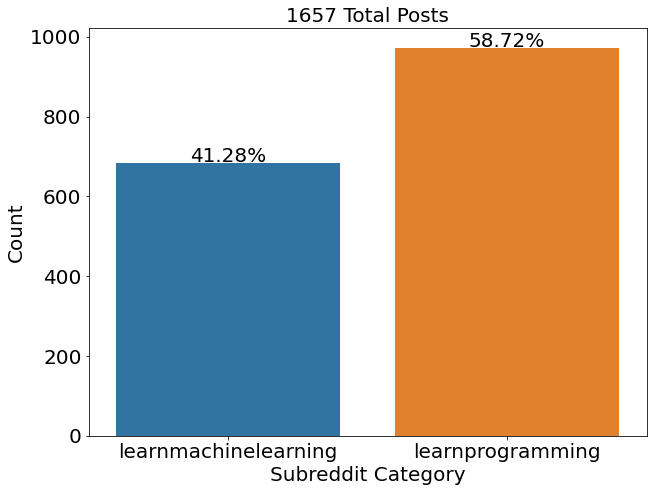

In [8]:
fig = plt.figure(figsize=(10, 7.5))
total = sum(master_df.selftext)
ax = sns.barplot(x = master_df.index, y = master_df.selftext)
ax.set_title('{} Total Posts'.format(total), fontsize = 20)
ax.set_xlabel('Subreddit Category', fontsize = 20)
ax.set_ylabel('Count', fontsize = 20)
ax.tick_params(labelsize=20)

for p in ax.patches:
    ax.annotate('{}%'.format(round(p.get_height()/total * 100, 2) ), (p.get_x() + p.get_width() / 2, p.get_height() + 15), 
                ha = 'center', va = 'center',size = 20)


The total posts works out to be 1657 posts of which 58.72% are posts from Learn Programming and 41.28% are from Learn Machine Learning. This works out to be a baseline accuracy of 0.5869. The ratio of the posts are not completely equal but not substantial enough to affect the accuracy scores.

### Plot Word Cloud

Word Cloud shows the most common words used. The bigger the font size means the more frequent the appearance of the particular word.

From the results below, appears that learning is one of the more frequent words appearing in both subreddits

In [9]:
def create_wordcloud(data, title):
    wordcloud = WordCloud(
        background_color='black',
        max_words=500,
        max_font_size=70,
        scale=3).generate(str(data))

    fig = plt.figure(1, figsize=(12, 10))
    plt.axis('off')
    if title:
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

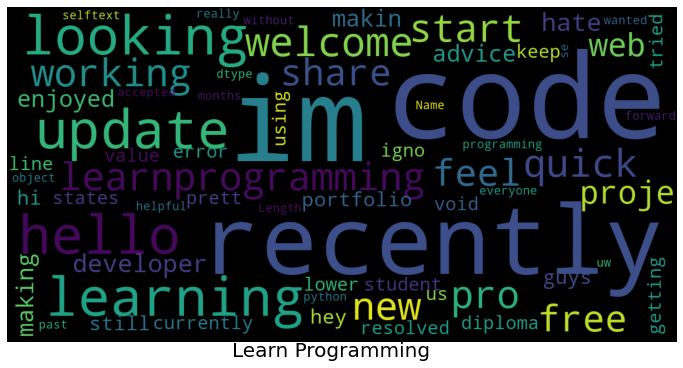

In [10]:
create_wordcloud(combined_df['selftext'][combined_df['subreddit'] == 1], 'Learn Programming')


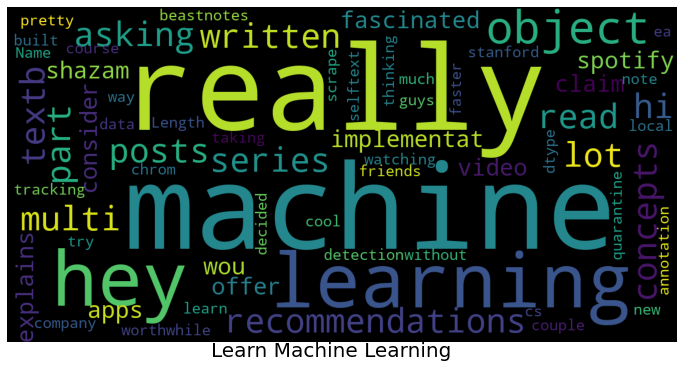

In [11]:
create_wordcloud(combined_df['selftext'][combined_df['subreddit'] == 0], 'Learn Machine Learning')

## Top Words

Count vectorizer provides us with the count of words to help us identify the top common 20 words. 

We will identify the column of interest for easier manipulation and set them as X and y.

In [12]:
X = combined_df['selftext']
y = combined_df['subreddit']

In [13]:
# only words appearing in minimum 20 documents and select a maximum of 2000 features

cvec = CountVectorizer(min_df = 20, max_features = 2000)
common_cvec = cvec.fit_transform(X)
common_cvec = pd.DataFrame(common_cvec.todense(), 
                        columns=cvec.get_feature_names())

In [14]:
# Create a data frame of the most common words 

n_words = 20
words = list(common_cvec.sum().sort_values(ascending=False)[:n_words].index)
common_cvec['subreddit'] = y.values
cvec_train_small = common_cvec.groupby('subreddit').sum()[words]

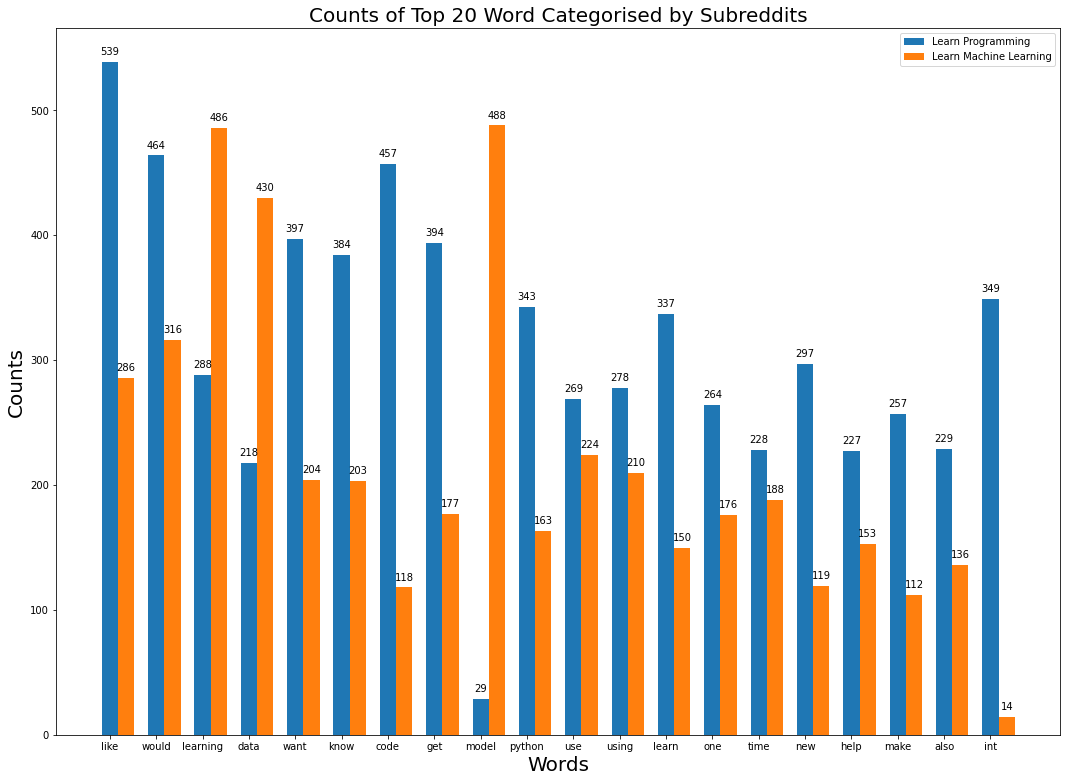

In [15]:
words_program = words
words_count_program = cvec_train_small.loc[1]
words_ml = words
words_count_ml = cvec_train_small.loc[0]
width = 0.35       
ind = np.arange(n_words)

fig, ax = plt.subplots(figsize=(18, 13))
rects1 = ax.bar(ind, words_count_program, width)
rects2 = ax.bar(ind+width, words_count_ml, width)

# add some text for labels, title and axes ticks
ax.set_ylabel('Counts', fontsize = 20)
ax.set_xlabel('Words', fontsize = 20)
ax.set_title('Counts of Top 20 Word Categorised by Subreddits', fontsize = 20)
ax.set_xticks(ind)
ax.set_xticklabels(words)

ax.legend((rects1[0], rects2[0]), ('Learn Programming', 'Learn Machine Learning'))

for p in ax.patches:
    ax.annotate(format(p.get_height()), (p.get_x() + p.get_width() / 2, p.get_height()), 
                ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points', size = 10)

plt.show()

The graph above shows the top 20 common words based on their counts in the posts, categorised into each subreddit. From this list, there is no word that appears to frequently appear in both subreddits.

In [16]:
def subplot_graphs(list_veccounts, list_of_titles, list_of_xlabels):
    nrows = int(np.ceil(len(list_veccounts)/2)) 
    fig, ax = plt.subplots(nrows=nrows, ncols=2, figsize=(20,10)) 
    ax = ax.ravel() 
    for i in range(len(list_veccounts)): 
        ax[i].barh(list_veccounts[i].keys(),width=list_veccounts[i],color='b')
        ax[i].set_title(list_of_titles[i],fontsize=20)
        ax[i].set_xlabel(list_of_xlabels[i],fontsize=16)
        ax[i].set_ylabel('Word', fontsize=16)
        ax[i].tick_params(axis="x", labelsize=14)
        ax[i].tick_params(axis="y", labelsize=14)
    plt.tight_layout()

def plot_graph(data,title_suffix):
  
    cvec = CountVectorizer()
    tvec = TfidfVectorizer()

    # Explore CountVectorizer token counts
    cvec_count = pd.DataFrame(cvec.fit_transform(data).todense(),
                           columns=cvec.get_feature_names()).sum(axis=0)

    # Explore TfidfVectorizer token count
    tvec_count = pd.DataFrame(tvec.fit_transform(data).todense(),
                           columns=tvec.get_feature_names()).sum(axis=0)
    
    subplot_graphs([cvec_count.sort_values(ascending=False).head(20),tvec_count.sort_values(ascending=False).head(20)],
                   ['Top 20 CountVectorized Words in '+title_suffix,'Top 20 TfidfVectorized Words in '+title_suffix],
                   ['count','tfidf value'])

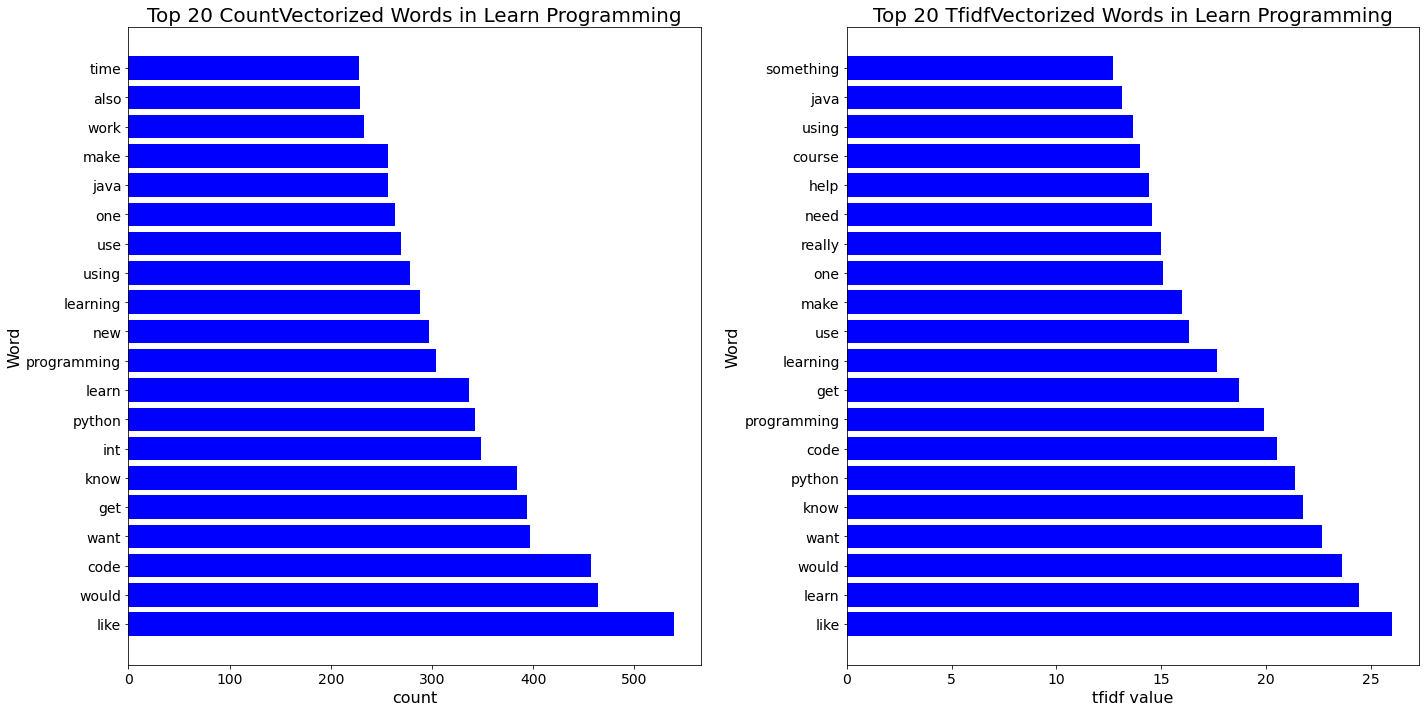

In [17]:
plot_graph(combined_df['selftext'][combined_df['subreddit'] == 1],'Learn Programming')


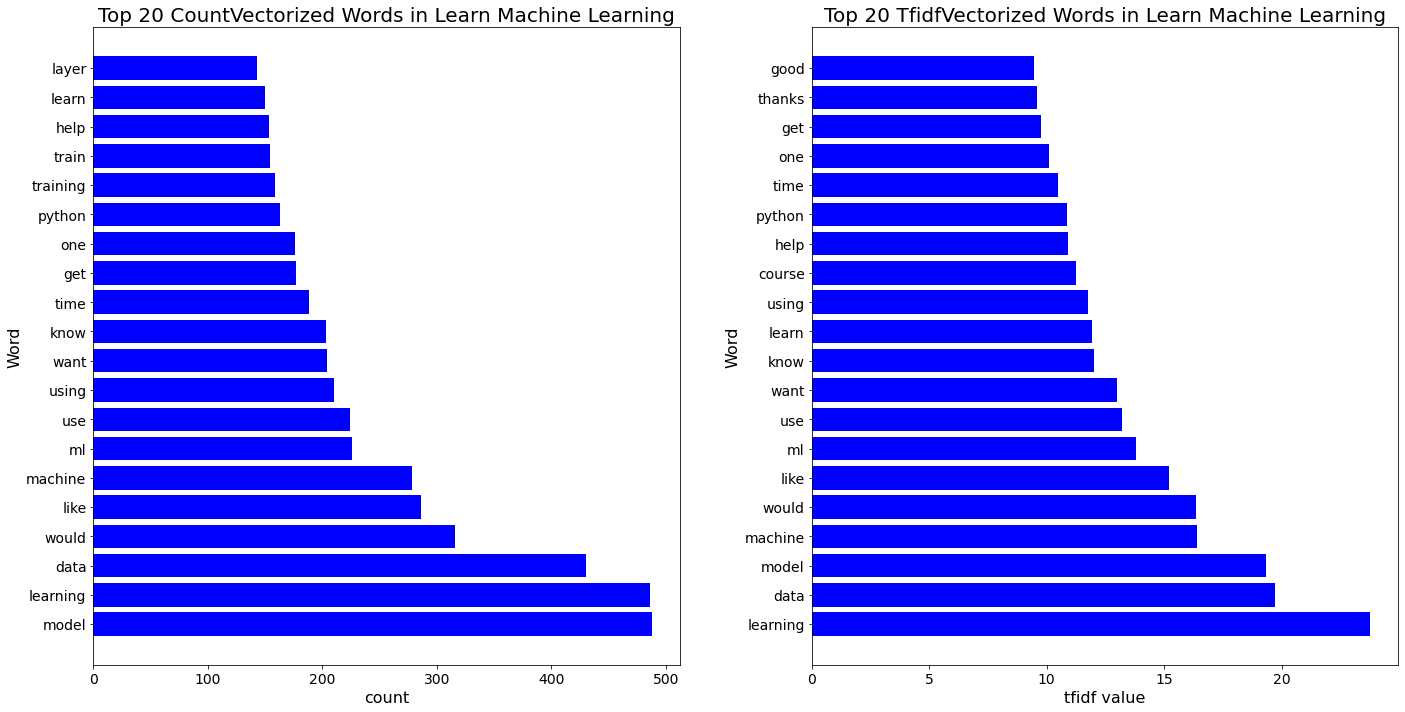

In [69]:
plot_graph(combined_df['selftext'][combined_df['subreddit'] == 0],'Learn Machine Learning')

From the above graphs, it is clear that the use count vectorizer or tfidf vectorizer yields some different words therefore we will apply the the classification models using both vectorizers to select one with highest accuracy

## Feature Engineering

### Customising Stopwords
In order to create a list of customised stop words, the absolute value of difference in the count of word appearing each subreddit is taken and included them in the list of stop words should the difference be less than 30. This is in order to reduce the common words for both subreddits which may affect the classification process and ensuring only unique words are left. 

In [18]:
common_cvec = common_cvec.groupby('subreddit').sum()
common_words = []

for words in common_cvec:
    if (abs(common_cvec[words].loc[0] - common_cvec[words].loc[1]) < 30):
        common_words.append(words)

In [19]:
len(common_words)

528

### Function

We will create 2 functions which will aid in selecting the optimum hyerparameters, fit and test our models.

pipeline_gridsearch will create a pipeline and perform a gridsearch on hyperparameters which we will define. Then perform a fit and test on our train data to provide us a score

fit_and_test will fit, test and perform predictions on our train and test data based on the optimal hyperparameters which our pipeline_gridsearch function had determined.

In [22]:
# Function for gridsearch

def pipeline_gridsearch(pipe, pipe_params, X_train, y_train):
    gs = GridSearchCV(pipe, param_grid=pipe_params, cv=5)
    gs.fit(X_train, y_train)
    print(gs.best_score_) # best_score_ is gridsearch's function
    print(gs.best_params_)# best_params_ is gridsearch's function

In [23]:
# Function for fit, test and predict after getting optimum parameters

def fit_and_test(best_feature, best_model, X_train, X_test, y_train, y_test):
    X_train_featured = best_feature.fit_transform(X_train)
    X_test_featured = best_feature.transform(X_test)
    best_model.fit(X_train_featured, y_train)
    train_score = cross_val_score(best_model, X_train_featured, y_train, cv=10)
    train_score = best_model.score(X_train_featured, y_train)
    test_score = best_model.score(X_test_featured, y_test)
    selected_features = best_feature.get_feature_names()
    
    coef = best_model.coef_  
    predict = best_model.predict(X_test_featured)
    report = classification_report(y_test, best_model.predict(X_test_featured))
    con_matrix = confusion_matrix(y_test, predict)
    tn, fp, fn, tp = confusion_matrix(y_test, predict).ravel()
    probabilities = best_model.predict_proba(X_test_featured)
    
    print('{} features were selected'.format(len(selected_features)))
    print('Cross Validated Mean Train Score is: {}'.format(train_score.mean()))
    print('Test Score is: {}'.format(test_score))
    
   
    return (coef, predict, con_matrix, report, tn, fp, fn, tp, probabilities)

## Selecting Original, Lemma or Stemmed Text
We will use count vectorizer with logistic regression to run a test on each of the 3 text to see which has the highest score to be used during the modeling prepping and modelling stage.

In [21]:
def stemming(selftext):
    p_stemmer = PorterStemmer()
    tokenizer = RegexpTokenizer(r'\w+')
    return [p_stemmer.stem(word) for word in tokenizer.tokenize(selftext)]

combined_df['stem_text'] = combined_df.selftext.apply(stemming)
combined_df['stem_text']= combined_df['stem_text'].str.join(' ')

In [20]:
def lemmatize(selftext):
    lemmatizer = WordNetLemmatizer()
    tokenizer = RegexpTokenizer(r'\w+')
    return [lemmatizer.lemmatize(word) for word in tokenizer.tokenize(selftext)]

combined_df['lemma_text'] = combined_df.selftext.apply(lemmatize)
combined_df['lemma_text']= combined_df['lemma_text'].str.join(' ')

In [24]:
best_cvec = CountVectorizer(stop_words = common_words)
best_logreg = LogisticRegression(solver = 'lbfgs')

In [25]:
columns = ['selftext', 'stem_text', 'lemma_text']

for i in columns:
    X = combined_df[i]
    y = combined_df['subreddit']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify = y,
                                                    test_size = 0.25,
                                                    random_state = 42)
    
    print(i)
    fit_and_test(best_cvec, best_logreg, X_train, X_test, y_train, y_test)
    print('')

selftext
8641 features were selected
Cross Validated Mean Train Score is: 0.9935587761674718
Test Score is: 0.9204819277108434

stem_text
6200 features were selected
Cross Validated Mean Train Score is: 0.9943639291465378
Test Score is: 0.9301204819277108

lemma_text
7798 features were selected
Cross Validated Mean Train Score is: 0.9935587761674718
Test Score is: 0.9228915662650602



## Modelling
Stem test achieved the best result and will be used for modelling

In [26]:
X = combined_df['stem_text']
y = combined_df['subreddit']

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify = y,
                                                    test_size = 0.25,
                                                    random_state = 42)

## Model 1 Count Vectorizer with Naive Bayesian's Multinomial NB
We first call our function to run a pipeline and grid search to determine the optimum hyperparameter from those which we had selected.

In [28]:
pipe = Pipeline([
    ('cvec', CountVectorizer(stop_words = common_words)),
    ('nb', MultinomialNB())])

In [80]:
pipe_params = {
    'cvec__max_features': [None, 5000], # find out how many max features is better
    'cvec__min_df': [1, 3], # find out how many min documents the word is required to appear
    'cvec__max_df': [.09, 1.0], # find out what is the best perimeter to ignore words 
    'cvec__ngram_range': [(1,1), (1,2)], # find out what is the best ngram to use
    
    'nb__alpha': [1.0, 3.0],
    'nb__fit_prior' : [True, False]
}

In [30]:
best_params = pipeline_gridsearch(pipe, pipe_params, X_train, y_train)

0.925939240834305
{'cvec__max_df': 1.0, 'cvec__max_features': 5000, 'cvec__min_df': 1, 'cvec__ngram_range': (1, 2), 'nb__alpha': 3.0, 'nb__fit_prior': False}


In [31]:
best_cvec = CountVectorizer(max_df = 1.0, max_features = None, min_df = 1, ngram_range = (1, 2), stop_words = common_words)
best_nb = MultinomialNB(alpha = 1.0, fit_prior = True)

In [32]:
m1_coef, m1_predict, m1_con_matrix, m1_report, m1_tn, m1_fp, m1_fn, m1_tp, m1_probabilities = fit_and_test(best_cvec, best_nb, X_train, X_test, y_train, y_test)

51673 features were selected
Cross Validated Mean Train Score is: 0.9903381642512077
Test Score is: 0.9301204819277108


After the initial round of running the models, Model 1 has the highest test score compared to the other models. Therefore further work below was done only on Model 1 to identify some of the important features which may help in increasing the scoring of the model and what are the features of the misclassified posts which could be improved.

In [33]:
m1_df = pd.DataFrame(m1_coef.T, index=best_cvec.get_feature_names(), columns=['coef'])

In [34]:
m1_df.coef.sort_values(ascending=False).head(30)

learn      -5.545177
use        -5.628474
code       -5.680660
like       -5.749972
get        -5.834811
want       -5.888299
program    -5.893809
work       -5.950643
would      -5.992440
know       -6.061868
int        -6.115572
tri        -6.194466
make       -6.213299
start      -6.347374
new        -6.347374
java       -6.400958
python     -6.414815
class      -6.447915
need       -6.447915
project    -6.462443
help       -6.472247
one        -6.482148
go         -6.502250
thank      -6.549011
look       -6.559707
time       -6.592496
realli     -6.598067
cours      -6.614969
file       -6.626398
function   -6.655555
Name: coef, dtype: float64

In [35]:
# Code obtained online to derive the best features
# https://stackoverflow.com/questions/11116697/how-to-get-most-informative-features-for-scikit-learn-classifiers

def important_features(best_cvec,best_nb,n=20):
    class_labels = best_nb.classes_
    feature_names =best_cvec.get_feature_names()
    topn_class1 = sorted(zip(best_nb.feature_count_[0], feature_names),reverse=True)[:n]
    topn_class2 = sorted(zip(best_nb.feature_count_[1], feature_names),reverse=True)[:n]
    print("Important words for learnmachinelearning")
    for coef, feat in topn_class1:
        print(class_labels[0], coef, feat)
    print("-----------------------------------------\n")
    print("Important words for learnprogramming")
    for coef, feat in topn_class2:
        print(class_labels[1], coef, feat)

In [36]:
important_features(best_cvec, best_nb, 15)

Important words for learnmachinelearning
0 482.0 learn
0 440.0 model
0 398.0 use
0 320.0 data
0 244.0 train
0 231.0 would
0 206.0 machin
0 203.0 like
0 197.0 work
0 193.0 machin learn
0 188.0 want
0 169.0 imag
0 165.0 get
0 164.0 ml
0 163.0 know
-----------------------------------------

Important words for learnprogramming
1 512.0 learn
1 471.0 use
1 447.0 code
1 417.0 like
1 383.0 get
1 363.0 want
1 361.0 program
1 341.0 work
1 327.0 would
1 305.0 know
1 289.0 int
1 267.0 tri
1 262.0 make
1 229.0 start
1 229.0 new


Despite identifying the stop words common for both subreddits, there are still stop words which remain common to both subreddits such as learn, work, use, want like. To increase the accuracy in future, it might be worthy to include these words to the stopwords. 

In [37]:
# pred learningmachinelearning = 0 (Negative)
# pred learnprogramming = 1 (Positive)

cm1_df = pd.DataFrame(m1_con_matrix, columns=['Pred Machine Learning', 'Pred Learn Programming'], index=['Actual Learn Machine Learning', 'Actual Learn Programming'])
cm1_df

,Pred Machine Learning,Pred Learn Programming
Actual Learn Machine Learning,154,17
Actual Learn Programming,12,232


In [38]:
print(m1_report)

              precision    recall  f1-score   support

           0       0.93      0.90      0.91       171
           1       0.93      0.95      0.94       244

    accuracy                           0.93       415
   macro avg       0.93      0.93      0.93       415
weighted avg       0.93      0.93      0.93       415



In [39]:
#Transform X_test based on cvec
X_test_featured = best_cvec.transform(X_test)

In [40]:
#Obtain the predictions
predictions = best_nb.predict(X_test_featured)

In [41]:
#Create a series of the predictions
y_pred = pd.Series(predictions)
y_pred.index = y_test.index

In [42]:
#Identify the misclassified posts
predicted = y_test!=predictions

misclassify_df = pd.DataFrame({'text':X_test[predicted],'actual':y_test[predicted],'predicted':y_pred[predicted]})
misclassify_df.head(20)

,text,actual,predicted
1658,hey compani beastnot built note take chrome ex...,0,1
388,new industri dont know requir e data scientist...,1,0
1576,word run inform without risk avail public,0,1
1435,tri get head around legal came across apach li...,0,1
33,reason know repli would appreci,1,0
4,hey guy current im diploma student im pretti n...,1,0
1461,recommend,0,1
449,thing class physic teacher reach differenti eq...,1,0
211,migrat hana best practic hana evolut sp hana a...,1,0
1087,found aw sagemak handi jump run ml code annoy ...,0,1


In [43]:
# confirming the indx 1658 against online website which is indeed in subreddit:0
input_txt = X_test.loc[1658]
print(input_txt)

print(y_test.loc[1658])

hey compani beastnot built note take chrome extens design work coursera uniqu featur allow note take browser watch lectur longer paus flip browser take note free use first three coursebook wrote articl want learn
0


In [44]:
#Print out the text for the misclassified posts
for i in misclassify_df[(misclassify_df['actual'] - misclassify_df['predicted']) < 0]['text']:
    print(i)
    print('-'*10)

hey compani beastnot built note take chrome extens design work coursera uniqu featur allow note take browser watch lectur longer paus flip browser take note free use first three coursebook wrote articl want learn
----------
word run inform without risk avail public
----------
tri get head around legal came across apach licens one facebook repo allow use commerci purpos wonder would avenu allow use code titl ask would legal compos code read research paper use commerci product thank
----------
recommend
----------
found aw sagemak handi jump run ml code annoy upload download file ui copi privat github key set ssh month ago final decid write guid hope go help
----------
beginn ml sometim feel lost know someon person studi ml would awesom someon mentor studi buddi could dm without hesit
----------
hello would like creat custom real time object detect app prefer pytorch peopl download mac pc linux without instal python anyth els except one app would like work old slow comput hope program fa

On a high level basis, the posts cannot be easily identifed the rationale of the misclassifications especially after stemming of the texts and perhaps more information could have been in the title itself. It would be worthy to combine the title with the selftext before running the models. 

## Model 2 Tfidf Vectorizer with Naive Bayesian's Multinomial NB

In [45]:
pipe = Pipeline([
    ('tvec', TfidfVectorizer(stop_words = common_words)),
    ('nb', MultinomialNB())])

In [46]:
pipe_params = {
    'tvec__max_features': [None, 5000], # find out how many max features is better
    'tvec__min_df': [1, 2], # find out how many min documents the word is required to appear for it to be counted
    'tvec__max_df': [0.9, 1.0], # find out what is the best perimeter to ignore words whether the words appear in 90% or 95% of documents
    'tvec__ngram_range': [(1,1), (1,2)], # find out what is the best ngram to use
    
    'nb__alpha': [1.0, 3.0],
    'nb__fit_prior' : [True, False]
}

In [47]:
best_params = pipeline_gridsearch(pipe, pipe_params, X_train, y_train)

0.908213499157922
{'nb__alpha': 1.0, 'nb__fit_prior': False, 'tvec__max_df': 0.9, 'tvec__max_features': 5000, 'tvec__min_df': 1, 'tvec__ngram_range': (1, 2)}


In [48]:
best_tvec = TfidfVectorizer(max_df = 0.9, max_features = 5000, min_df = 1, ngram_range = (1, 2), stop_words = common_words)
best_nb = MultinomialNB(alpha = 3.0, fit_prior = False)

In [49]:
m2_coef, m2_predict, m2_con_matrix, m2_report, m2_tn, m2_fp, m2_fn, m2_tp, m2_probabilities = fit_and_test(best_tvec, best_nb, X_train, X_test, y_train, y_test)

5000 features were selected
Cross Validated Mean Train Score is: 0.9388083735909822
Test Score is: 0.9108433734939759


In [50]:
print(m2_report)

              precision    recall  f1-score   support

           0       0.97      0.81      0.88       171
           1       0.88      0.98      0.93       244

    accuracy                           0.91       415
   macro avg       0.92      0.90      0.91       415
weighted avg       0.92      0.91      0.91       415



## Model 3 Tfidf Vectorizer with Logistic Regression

In [51]:
pipe = Pipeline([
    ('tvec', TfidfVectorizer(stop_words = common_words)),
    ('lr', LogisticRegression(solver = 'liblinear'))])

In [52]:

pipe_params = {
    'tvec__max_features': [None, 5000], # find out how many max features is better
    'tvec__min_df': [1, 2], # find out how many min documents the word is required to appear for it to be counted
    'tvec__max_df': [0.9, 1.0], # find out what is the best perimeter to ignore words whether the words appear in 90% or 95% of documents
    'tvec__ngram_range': [(1,1), (1,2)], # find out what is the best ngram to use
        
    'lr__C': [1.0, 0.5],
    'lr__class_weight' : [None, 'balanced'],
    'lr__penalty' : ['l1', 'l2']
}

In [53]:
best_params = pipeline_gridsearch(pipe, pipe_params, X_train, y_train)

0.9074297188755021
{'lr__C': 0.5, 'lr__class_weight': 'balanced', 'lr__penalty': 'l2', 'tvec__max_df': 0.9, 'tvec__max_features': 5000, 'tvec__min_df': 1, 'tvec__ngram_range': (1, 2)}


In [54]:
best_tvec = TfidfVectorizer(max_df = 0.9, max_features = None, min_df = 2, ngram_range = (1, 2), stop_words = common_words)
best_logreg = LogisticRegression(C = 1.0, class_weight = None, penalty = 'l2', solver = 'liblinear')

In [55]:
m3_coef, m3_predict, m3_con_matrix, m3_report, m3_tn, m3_fp,m3_fn, m3_tp, m3_probabilities = fit_and_test(best_tvec, best_logreg, X_train, X_test, y_train, y_test)

7954 features were selected
Cross Validated Mean Train Score is: 0.9573268921095008
Test Score is: 0.9156626506024096


In [56]:
print(m3_report)

              precision    recall  f1-score   support

           0       0.97      0.82      0.89       171
           1       0.89      0.98      0.93       244

    accuracy                           0.92       415
   macro avg       0.93      0.90      0.91       415
weighted avg       0.92      0.92      0.91       415



## Model 4 Count Vectorizer With Logistic Regression

In [57]:
#m4_steps = [('m4_cvec', CountVectorizer(stop_words = common_words)),
#    ('m4_lr', LogisticRegression(solver = 'liblinear'))]

In [58]:
#pipe_4 = Pipeline(m4_steps)

In [59]:
pipe = Pipeline([
    ('cvec', CountVectorizer(stop_words = common_words)),
    ('lr', LogisticRegression(solver = 'liblinear'))])

In [60]:
pipe_params = {
    'cvec__max_features': [None, 5000], # find out how many max features is better
    'cvec__min_df': [1, 2], # find out how many min documents the word is required to appear for it to be counted
    'cvec__max_df': [0.9, 1.0], # find out what is the best perimeter to ignore words whether the words appear in 90% or 95% of documents
    'cvec__ngram_range': [(1, 1), (1, 2)], # find out what is the best ngram to use
            
    'lr__C': [1.0, 0.9],
    'lr__class_weight' : [None, 'balanced'],
    'lr__penalty' : ['l1', 'l2']
}

In [61]:
pipeline_gridsearch(pipe, pipe_params, X_train, y_train)

0.8897104547221144
{'cvec__max_df': 0.9, 'cvec__max_features': None, 'cvec__min_df': 1, 'cvec__ngram_range': (1, 2), 'lr__C': 1.0, 'lr__class_weight': 'balanced', 'lr__penalty': 'l2'}


In [62]:
best_cvec = CountVectorizer(max_df = 0.9, max_features = None, min_df = 1, ngram_range = (1, 2), stop_words = common_words)
best_logreg = LogisticRegression(C = 1.0, class_weight = None, penalty = 'l2', solver = 'lbfgs')

In [63]:
m4_coef, m4_predict, m4_con_matrix, m4_report, m4_tn, m4_fp, m4_fn, m4_tp, m4_probabilities = fit_and_test(best_cvec, best_logreg, X_train, X_test, y_train, y_test)


51673 features were selected
Cross Validated Mean Train Score is: 1.0
Test Score is: 0.9253012048192771


In [64]:
cm4_df = pd.DataFrame(m4_con_matrix, columns=['Pred Learn Machine Learning', 'Pred Learn Programming'], index=['Actual Learn Machine Learning', 'Actual Learn Programming'])
cm4_df

,Pred Learn Machine Learning,Pred Learn Programming
Actual Learn Machine Learning,149,22
Actual Learn Programming,9,235


In [65]:
print(m4_report)

              precision    recall  f1-score   support

           0       0.94      0.87      0.91       171
           1       0.91      0.96      0.94       244

    accuracy                           0.93       415
   macro avg       0.93      0.92      0.92       415
weighted avg       0.93      0.93      0.92       415



The classification results of Model 4 was noticed to be very close to Model 1. Both the models gave an accuracy of 0.93 and the f1 scores for both models are the same. However, Model 1 gave an equal precision score of 0.93 for both subreddits as compared to 0.91 and 0.94 for Model 4.

## Model 5 Count Vectorizer with Random Forest

In [66]:
pipe = Pipeline([
    ('cvec', CountVectorizer(stop_words = common_words)),
    ('rf', RandomForestClassifier(criterion = 'gini', n_estimators=99, max_depth=9))])

pipe_params = {
    'cvec__max_features': [None, 5000], # find out how many max features is better
    'cvec__min_df': [1, 2], # find out how many min documents the word is required to appear for it to be counted
    'cvec__max_df': [0.9, 1.0], # find out what is the best perimeter to ignore words whether the words appear in 90% or 95% of documents
    'cvec__ngram_range': [(1, 1), (1, 2)], # find out what is the best ngram to use
    'rf__n_estimators': [100,200,300],
    'rf__max_depth':[50,75,100]
}
gs = GridSearchCV(pipe, param_grid=pipe_params, cv=5, verbose = 1)
gs.fit(X_train, y_train)
print(f"Best params: {gs.best_params_}")
print(f"Train score: {round(gs.best_score_, 4)}")
print(f"Test score: {round(gs.best_score_, 4)}")
print(f'Number of features: {len(gs.best_estimator_.named_steps.cvec.get_feature_names())}')

Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 720 out of 720 | elapsed: 12.4min finished


Best params: {'cvec__max_df': 1.0, 'cvec__max_features': None, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 1), 'rf__max_depth': 75, 'rf__n_estimators': 300}
Train score: 0.8946
Test score: 0.8946
Number of features: 2802


In [67]:
rf_cvec = Pipeline([
    ('cvec', CountVectorizer(stop_words = common_words)),
    ('rf', RandomForestClassifier(criterion = 'gini', n_estimators=99, max_depth=9))])
rf_cvec.fit(X_train, y_train)
y_pred = rf_cvec.predict_proba(X_test)
y_pred = np.where(y_pred[:,1]>=0.5,1,0)

pipe.fit(X_train, y_train)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=['Pred Learn Machine Learning', 'Pred Learn Programming']))

[[103  68]
 [  2 242]]
                             precision    recall  f1-score   support

Pred Learn Machine Learning       0.98      0.60      0.75       171
     Pred Learn Programming       0.78      0.99      0.87       244

                   accuracy                           0.83       415
                  macro avg       0.88      0.80      0.81       415
               weighted avg       0.86      0.83      0.82       415



## Model 6 Tfidf Vectorizer with Random Forest

In [71]:
pipe = Pipeline([
    ('tvec', TfidfVectorizer(stop_words = common_words)),
    ('rf', RandomForestClassifier(criterion = 'gini', n_estimators=99, max_depth=9))])

pipe_params = {
    'tvec__max_features': [None, 5000], # find out how many max features is better
    'tvec__min_df': [1, 2], # find out how many min documents the word is required to appear for it to be counted
    'tvec__max_df': [0.9, 1.0], # find out what is the best perimeter to ignore words whether the words appear in 90% or 95% of documents
    'tvec__ngram_range': [(1,1), (1,2)], # find out what is the best ngram to use
    'rf__n_estimators': [100,200,300],
    'rf__max_depth':[50,75,100]
}
gs = GridSearchCV(pipe, param_grid=pipe_params, cv=5, verbose = 1)
gs.fit(X_train, y_train)
print(f"Best params: {gs.best_params_}")
print(f"Train score: {round(gs.best_score_, 4)}")
print(f"Test score: {round(gs.best_score_, 4)}")
print(f'Number of features: {len(gs.best_estimator_.named_steps.tvec.get_feature_names())}')

Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 720 out of 720 | elapsed: 12.4min finished


Best params: {'rf__max_depth': 100, 'rf__n_estimators': 200, 'tvec__max_df': 1.0, 'tvec__max_features': None, 'tvec__min_df': 2, 'tvec__ngram_range': (1, 1)}
Train score: 0.897
Test score: 0.897
Number of features: 2802


In [72]:
rf_tvec = Pipeline([
    ('tvec', TfidfVectorizer(stop_words = common_words)),
    ('rf', RandomForestClassifier(criterion = 'gini', n_estimators=99, max_depth=9))])
rf_tvec.fit(X_train, y_train)
y_pred = rf_tvec.predict_proba(X_test)
y_pred = np.where(y_pred[:,1]>=0.5,1,0)

pipe.fit(X_train, y_train)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=['Pred Learn Machine Learning', 'Pred Learn Programming']))

[[ 96  75]
 [  1 243]]
                             precision    recall  f1-score   support

Pred Learn Machine Learning       0.99      0.56      0.72       171
     Pred Learn Programming       0.76      1.00      0.86       244

                   accuracy                           0.82       415
                  macro avg       0.88      0.78      0.79       415
               weighted avg       0.86      0.82      0.80       415



## Evaluating Selected Model

In [73]:
pred_proba = [i[1] for i in m1_probabilities]

pred_df = pd.DataFrame({'true_values': y_test,
                        'pred_probs':pred_proba})

In [74]:
#AUC Scoring of Model 1
AUC1 = round(roc_auc_score(pred_df["true_values"], pred_df["pred_probs"]),3)
AUC1

0.973

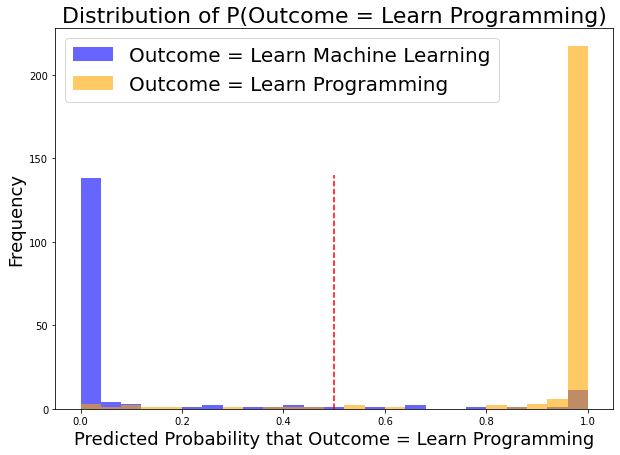

In [83]:
# Create figure.
plt.figure(figsize = (10,7))

# Create two histograms of observations.
plt.hist(pred_df[pred_df['true_values'] == 0]['pred_probs'],
         bins=25,
         color='blue',
         alpha = 0.6,
         label='Outcome = Learn Machine Learning')
plt.hist(pred_df[pred_df['true_values'] == 1]['pred_probs'],
         bins=25,
         color='orange',
         alpha = 0.6,
         label='Outcome = Learn Programming')

# Add vertical line at P(Outcome = 1) = 0.5.
plt.vlines(x=0.5,
           ymin = 0,
           ymax = 140,
           color='r',
           linestyle = '--')

# Label axes.
plt.title('Distribution of P(Outcome = Learn Programming)', fontsize=22)
plt.ylabel('Frequency', fontsize=18)
plt.xlabel('Predicted Probability that Outcome = Learn Programming', fontsize=18)

# Create legend.
plt.legend(fontsize=20);

In [76]:
pred_proba = [i[1] for i in m4_probabilities]

pred_df4 = pd.DataFrame({'true_values4': y_test,
                        'pred_probs4':pred_proba})

In [77]:
AUC4 = round(roc_auc_score(pred_df4["true_values4"], pred_df4["pred_probs4"]),3)
AUC4

0.978

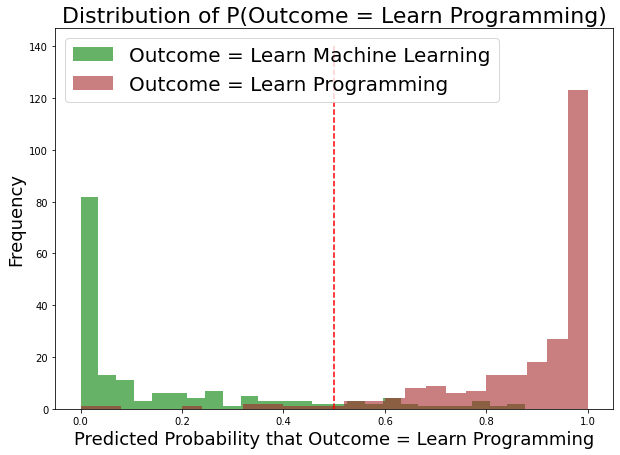

In [82]:
# Create figure.
plt.figure(figsize = (10,7))

# Create two histograms of observations.
plt.hist(pred_df4[pred_df4['true_values4'] == 0]['pred_probs4'],
         bins=25,
         color='green',
         alpha = 0.6,
         label='Outcome = Learn Machine Learning')
plt.hist(pred_df4[pred_df4['true_values4'] == 1]['pred_probs4'],
         bins=25,
         color='brown',
         alpha = 0.6,
         label='Outcome = Learn Programming')

# Add vertical line at P(Outcome = 1) = 0.5.
plt.vlines(x=0.5,
           ymin = 0,
           ymax = 140,
           color='r',
           linestyle = '--')

# Label axes.
plt.title('Distribution of P(Outcome = Learn Programming)', fontsize=22)
plt.ylabel('Frequency', fontsize=18)
plt.xlabel('Predicted Probability that Outcome = Learn Programming', fontsize=18)

# Create legend.
plt.legend(fontsize=20);

The above 2 graphs show the distribution of the predicted probabilities. There are 2 peaks at each end, which is characteristic of a bimodal distribution. 

In a perfect model where every classification is correct, the columns will be distinctively on each side of the dotted line.

From the above, we can see that the ratio of misclassifications are lower on Model 1 compared to Model 4 where the columns are more distinctively on both ends. 

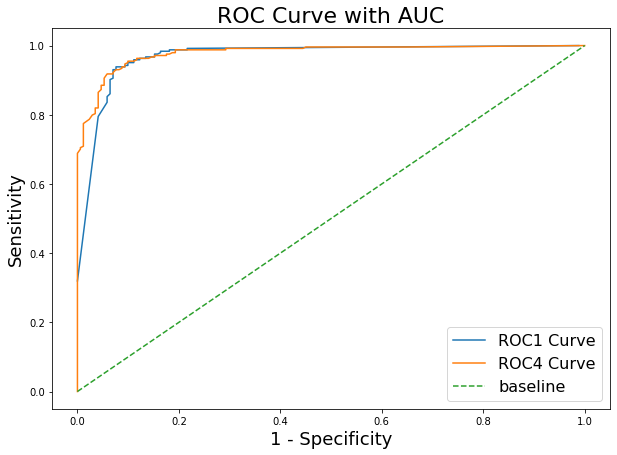

In [81]:
# Create figure.
plt.figure(figsize = (10,7))

# Create threshold values. (Dashed red line in image.)
thresholds = np.linspace(0, 1, 200)

# Define function to calculate sensitivity. (True positive rate.)
def TPR(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
    false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
    return true_positive / (true_positive + false_negative)
    

# Define function to calculate 1 - specificity. (False positive rate.)
def FPR(df, true_col, pred_prob_col, threshold):
    true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
    return 1 - (true_negative / (true_negative + false_positive))
    
# Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
tpr_values = [TPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]
fpr_values = [FPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]
tpr4_values = [TPR(pred_df4, 'true_values4', 'pred_probs4', prob) for prob in thresholds]
fpr4_values = [FPR(pred_df4, 'true_values4', 'pred_probs4', prob) for prob in thresholds]

# Plot ROC curve.
plt.plot(fpr_values, # False Positive Rate on X-axis
         tpr_values, # True Positive Rate on Y-axis
         label='ROC1 Curve')

plt.plot(fpr4_values, # False Positive Rate on X-axis
         tpr4_values, # True Positive Rate on Y-axis
         label='ROC4 Curve')

# Plot baseline. (Perfect overlap between the two populations.)
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         label='baseline',
         linestyle='--')

# Label axes.
plt.title(f'ROC Curve with AUC', fontsize = 22)
plt.ylabel('Sensitivity', fontsize=18)
plt.xlabel('1 - Specificity', fontsize=18)


# Create legend.
plt.legend(fontsize=16);


The above shows a ROC AUC plot of Model 1 and Model 4. In a ROC curve the true positive rate (Sensitivity) is plotted in function of the false positive rate (100-Specificity) for different cut-off points of a parameter. Each point on the ROC curve represents a sensitivity/specificity pair corresponding to a particular decision threshold. The area under the ROC curve (AUC) is a measure of how well a parameter can distinguish between two diagnostic groups

In a good model is that the ROC AUC is above 0.5 and close to 1. An ROC AUC of 0.5, that means the positive and negative population overlaps perfectly, inferring that the model is bad. If it is at 1, it means that the model is able to classify all observations correctly. If the ROC AUC is below 0.5, it means that our model inversely classified the observations, positive is classified as negative and vice versa.

From the above we can see that our ROC AUC is Model 4 has a higher scoring compared to Model 1.



## Conclusion

In terms of scorings, Model 1 and 4 are very close in terms of the test scores and results from classification reports. Both the models gave an accuracy of 0.93 and the f1 scores for both models are the same. However, Model 1 gave an equal precision score of 0.93 for both subreddits as compared to 0.91 and 0.94 for Model 4. In this case where there is no preference of class 0 over class 1 or vice versa, the equal precision score of Model 1 is preferred. Both the AUC scores for Model 1 and 4 were also very close at 0.973 and 0.978 respectively which also suggest both models are high in their probability of predictions and since the cross validation mean train score for Model 1 is slightly lower than that of Model 4 which means less overfitting, Model 1 on the overall is the best performing.